In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torchvision.models as models
from tqdm import tqdm
# import copyimport matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os



In [114]:
def save_to_list():
    output_root = "output_samples2"
    X = []
    y = []
    l=[]
        
    label_to_index = {
        'AVM': 0,
        'Normal': 1,
        'Ulcer': 2
    }
    print(label_to_index)
    for root, _, files in os.walk(output_root):
        for file in files:
            if file.endswith(".bmp"): 
                input_path = os.path.join(root, file)

                base, ext = os.path.splitext(file)
                new_filename = f"{base}{ext}"
                image = cv2.imread(input_path)

                X.append(image)
                y.append(label_to_index[new_filename.split("_")[0]])
                l.append(new_filename)
    return X, y, l

X, y, l = save_to_list()

{'AVM': 0, 'Normal': 1, 'Ulcer': 2}


In [ ]:

# https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/2

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])  
        label = torch.tensor(self.labels[idx], dtype=torch.long) 

        if self.transform:
            image = self.transform(image)
            
        
        return image, label

In [72]:
class ResNet50Transfer(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Transfer, self).__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze all layers (optional: you can unfreeze later for fine-tuning)
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        for name, param in self.base_model.named_parameters():
            if "layer4" in name or "layer3" in name:  # Unfreeze only final block
                param.requires_grad = True

        in_features = self.base_model.fc.in_features  # Usually 2048
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes) 
        )

    def forward(self, x):
        return self.base_model(x)


In [73]:
model = ResNet50Transfer(num_classes=3) 
model.load_state_dict(torch.load("model_output_samples_25.04.pth", map_location=torch.device('cpu')))

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [74]:
def batch_predict(images):
    model.eval()
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) 
    device= torch.device('cpu')
    transformed = []
    for img in images:
        if isinstance(img, np.ndarray):
            img = (img * 255).astype(np.uint8)  # Przywróć do formatu obrazu
            pil_img = Image.fromarray(img)
            img_t = transform(pil_img)
            transformed.append(img_t)
    batch = torch.stack(transformed).to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

In [75]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

In [ ]:
len(X)

(890, 890, 890)

Predykcja: 0, Labels: 0
AVM_2024-08-07-08-01-08_46388.bmp 0


100%|██████████| 1000/1000 [00:38<00:00, 26.16it/s]


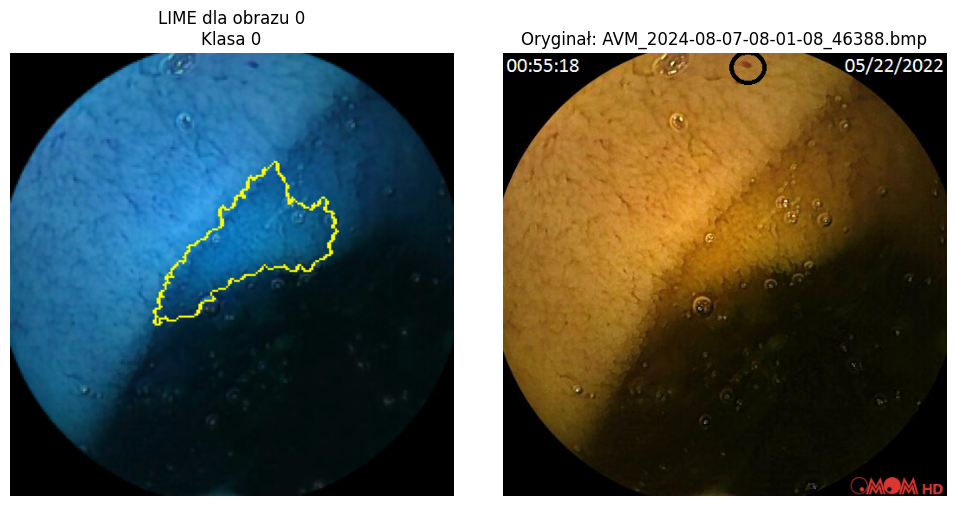

Predykcja: 0, Labels: 0
AVM_2024-08-07-08-08-26_88231.bmp 0


100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s]


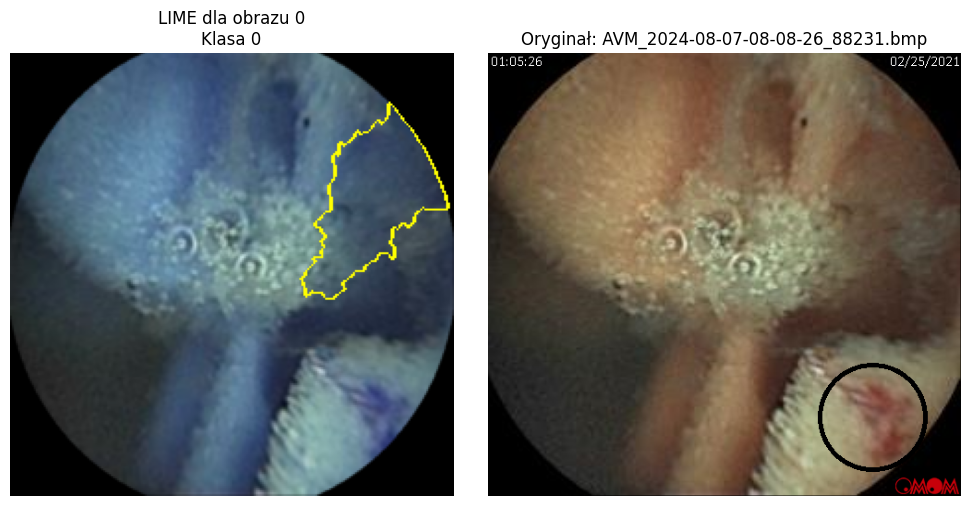

Predykcja: 0, Labels: 0
AVM_2024-08-07-08-16-02_12319.bmp 0


100%|██████████| 1000/1000 [00:37<00:00, 26.71it/s]


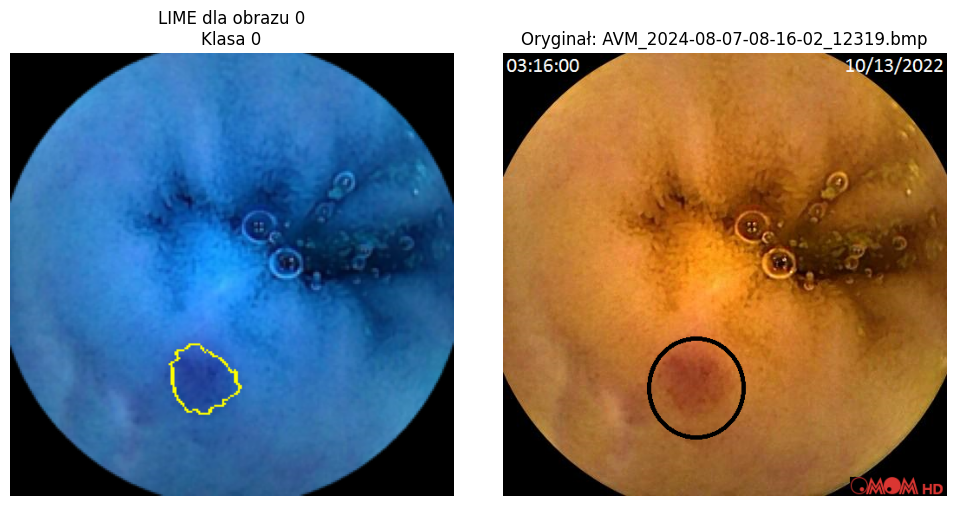

Predykcja: 0, Labels: 0
AVM_2024-08-07-08-20-48_67227.bmp 0


100%|██████████| 1000/1000 [00:38<00:00, 26.26it/s]


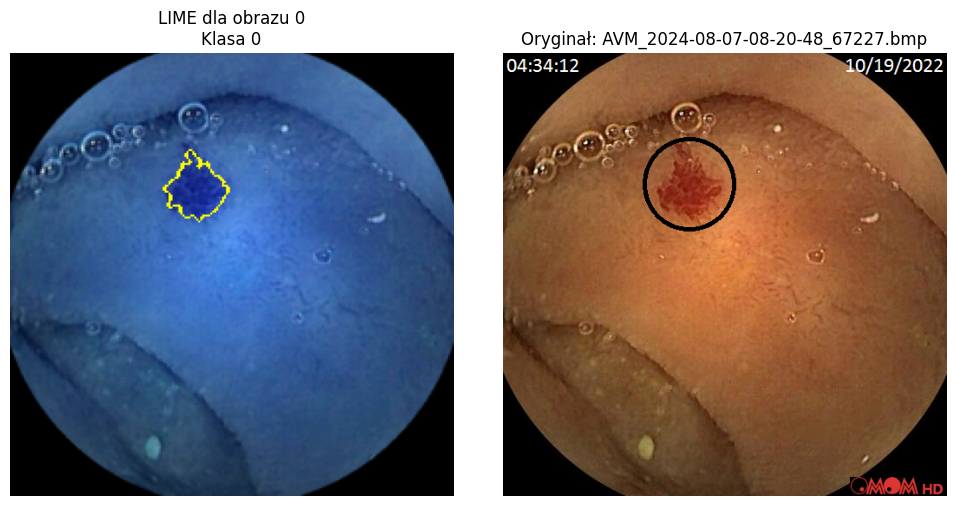

Predykcja: 1, Labels: 1
Normal_2024-08-07-07-47-35_28473.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-47-36_25221.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-48-57_11236.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-49-30_33007.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-50-54_29243.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-51-24_15517.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-51-57_40174.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-53-19_12557.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-54-25_23902.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-56-12_12219.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-56-12_46999.bmp 1
Predykcja: 1, Labels: 1
Normal_2024-08-07-07-57-26_43136.bmp 1
Predykcja: 2, Labels: 2
Ulcer_2024-08-07-08-27-43_91519.bmp 2


100%|██████████| 1000/1000 [00:37<00:00, 26.92it/s]


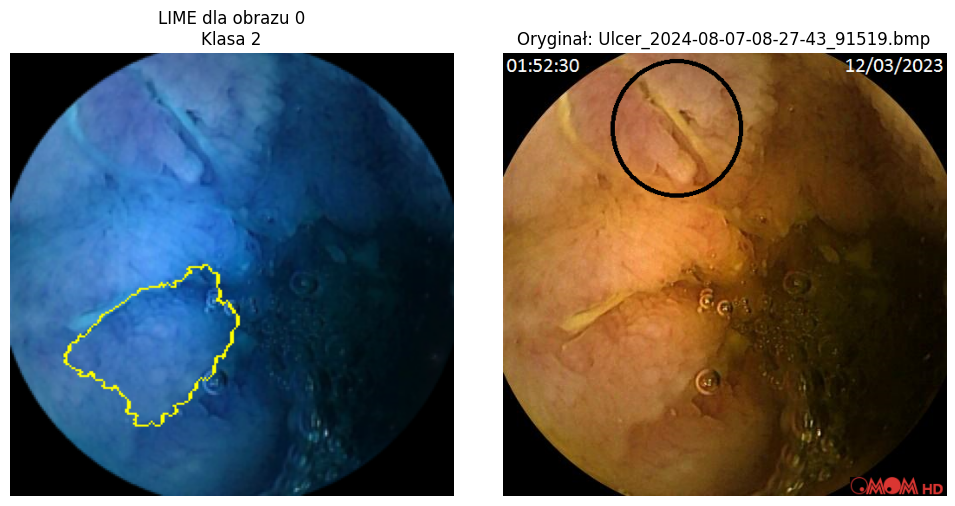

Predykcja: 2, Labels: 2
Ulcer_2024-08-07-08-29-50_80564.bmp 2


100%|██████████| 1000/1000 [00:50<00:00, 19.80it/s]


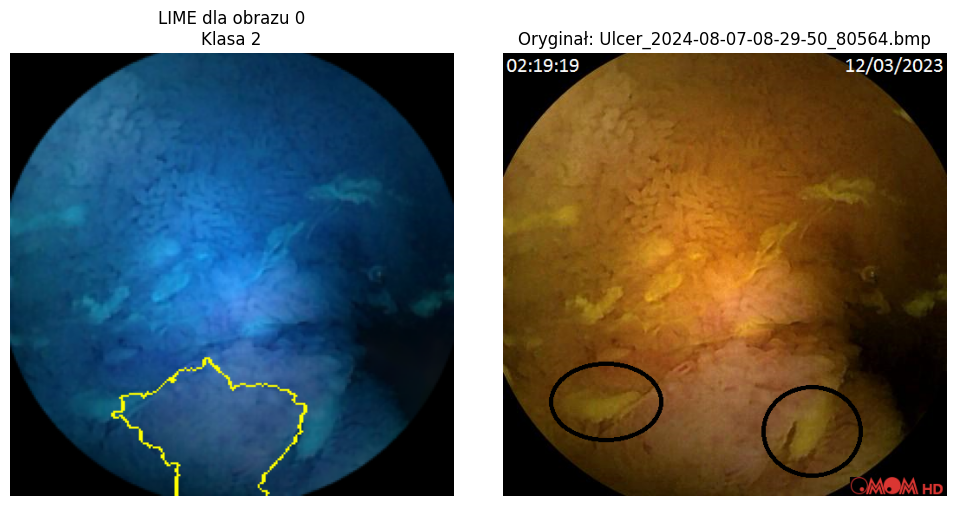

In [118]:
for k in range(1, 890, 50):
    test_dataset = ImageDataset([X[k]], [y[k]], transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    images, labels = list(test_loader)[0]
    images1, labels1 = next(iter(test_loader))
    
    model.eval()
    with torch.no_grad():
        logits = model(images1)
        prediction = torch.argmax(logits, dim=1)
    
    print(f"Predykcja: {prediction.item()}, Labels: {labels1.item()}")
    print(l[k], y[k])
    
    if labels1.item() == 1: 
        continue  # Pomijaj obrazy z etykietą 1 (Normal)
    
    for i, image in enumerate(images):

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        unnormalized = image.permute(1, 2, 0).numpy()
        unnormalized = unnormalized * std + mean
        unnormalized = np.clip(unnormalized, 0, 1)
        
        # LIME
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            unnormalized,
            batch_predict,
            top_labels=3,
            hide_color=0,
            num_samples=1000
        )
        temp, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=1,
            hide_rest=False
        )
        
        folder_path = "archive"
        file_name = l[k] 
        label_name = file_name.split("_")[0]  
        
        full_path = os.path.join(folder_path, label_name, file_name)
        if os.path.exists(full_path):
            original_image = mpimg.imread(full_path)
        else:
            print(f"Nie znaleziono pliku: {full_path}")
            original_image = np.zeros((224, 224, 3)) 

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(mark_boundaries(temp, mask))
        axes[0].set_title(f"LIME dla obrazu {i}\nKlasa {explanation.top_labels[0]}")
        axes[0].axis('off')

        axes[1].imshow(original_image)
        axes[1].set_title(f"Oryginał: {file_name}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()
